In [1]:
import os
import sys
sys.path.insert(0, '../')

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14

from scipy.interpolate import interp1d
from scipy.signal import butter, sosfiltfilt
from pydub import AudioSegment
import librosa

c:\Users\y1hli\anaconda3\envs\data-analysis\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [2]:
path = '../dataset/revision/'
target_date = '2024-08-12'

csv_files = [f for f in os.listdir(path) if f.endswith('.csv') and target_date in f]

dfs = []
for f in csv_files:
    filepath = os.path.join(path, f)
    df = pd.read_csv(filepath, header=None)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.columns = [
    'timestamp',
    'pd1',
    'pd2',
    'pd3',
    'pd4',
    'roll',
    'pitch',
    'yaw']
df = df.drop_duplicates()
df['timestamp'] = df['timestamp'] / 1000
df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,5.979,0.4389,0.5398,0.1780,0.4561,-1.0595,6.4718,180.0876
1,6.028,0.4384,0.5399,0.1761,0.4560,-0.8981,7.1419,180.1376
2,6.078,0.4385,0.5399,0.1758,0.4560,-0.8437,7.9602,180.1347
3,6.128,0.4384,0.5399,0.1766,0.4561,-1.0247,8.5293,180.2354
4,6.178,0.4383,0.5399,0.1760,0.4563,-1.2691,9.0962,180.2350
...,...,...,...,...,...,...,...,...
12281,963.178,0.4038,0.5481,0.2839,0.4633,-0.9163,50.2852,94.4888
12282,963.228,0.4030,0.5480,0.2841,0.4631,-0.2081,50.1978,95.0078
12283,963.278,0.4028,0.5479,0.2843,0.4631,0.3667,50.2312,95.5391
12284,963.328,0.4028,0.5478,0.2843,0.4634,-0.5126,50.3408,94.8635


In [3]:
# fill the missed data by interpolation
full_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max() + 0.05, 0.05)
full_df = pd.DataFrame({'timestamp': full_timestamps})
df = pd.merge_asof(full_df, df, on='timestamp', direction='forward')
df.iloc[:, 1:] = df.iloc[:, 1:].interpolate(method='cubic')
df = df.dropna()

In [4]:
# interpolate to 1000 Hz
high_res_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max(), 0.001)
high_res_df = pd.DataFrame({'timestamp': high_res_timestamps})
for column in df.columns[1:]:
    interpolator = interp1d(df['timestamp'], df[column], kind='cubic', fill_value='extrapolate')
    high_res_signal = interpolator(high_res_timestamps)
    high_res_df[column] = high_res_signal
high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,5.979,0.438900,0.539800,0.178000,0.456100,-1.059500,6.471800,180.087600
1,5.980,0.438887,0.539804,0.177888,0.456096,-1.049486,6.518270,180.086592
2,5.981,0.438874,0.539807,0.177779,0.456092,-1.039741,6.563907,180.085691
3,5.982,0.438862,0.539810,0.177674,0.456088,-1.030262,6.608719,180.084896
4,5.983,0.438850,0.539814,0.177572,0.456084,-1.021046,6.652716,180.084206
...,...,...,...,...,...,...,...,...
957345,963.324,0.402878,0.547874,0.284701,0.463518,-0.085391,50.209149,95.249080
957346,963.325,0.402882,0.547879,0.284719,0.463515,-0.039246,50.201299,95.288207
957347,963.326,0.402886,0.547884,0.284739,0.463512,0.008993,50.193182,95.329085
957348,963.327,0.402891,0.547889,0.284759,0.463508,0.059360,50.184795,95.371742


In [5]:
# butterworth filter
cutoff = [0.1, 20]
fs = 1000
for column in high_res_df.columns[1:]:
    sos = butter(2, cutoff, 'bandpass', output='sos', fs=fs)
    filtered_signal = sosfiltfilt(sos, high_res_df[column])
    high_res_df[column] = filtered_signal

high_res_df.iloc[:, 0] -= high_res_df.iloc[0, 0]
high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,0.000,-0.000738,0.000407,-0.004450,0.000374,2.866711,-8.910557,0.094773
1,0.001,-0.000749,0.000410,-0.004544,0.000371,2.876859,-8.876859,0.094362
2,0.002,-0.000761,0.000413,-0.004638,0.000368,2.887058,-8.842813,0.093967
3,0.003,-0.000773,0.000416,-0.004732,0.000365,2.897279,-8.808539,0.093593
4,0.004,-0.000784,0.000420,-0.004826,0.000362,2.907491,-8.774152,0.093246
...,...,...,...,...,...,...,...,...
957345,957.345,-0.000029,-0.000050,-0.000119,0.000011,-0.307289,0.073725,-0.250963
957346,957.346,-0.000026,-0.000045,-0.000106,0.000010,-0.275687,0.065911,-0.225193
957347,957.347,-0.000023,-0.000040,-0.000094,0.000009,-0.244889,0.058365,-0.200067
957348,957.348,-0.000020,-0.000035,-0.000082,0.000008,-0.215132,0.051132,-0.175781


In [6]:
color = ['#E84A4E', '#51546B', '#616EEB', '#E8C54A', '#4AE875', '#94885F', '#6B4545']

(831.0, 900.0)

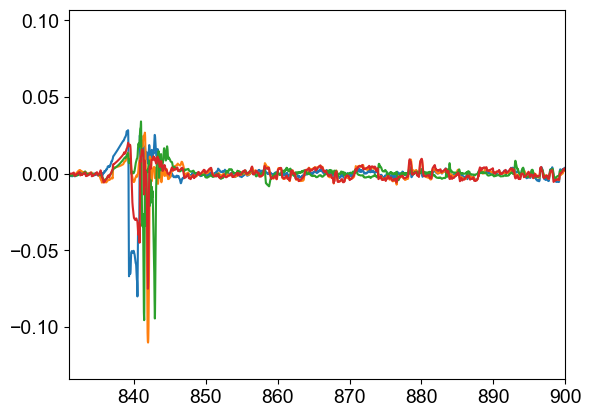

In [8]:
plt.plot(high_res_df['timestamp'], high_res_df['pd1'])
plt.plot(high_res_df['timestamp'], high_res_df['pd2'])
plt.plot(high_res_df['timestamp'], high_res_df['pd3'])
plt.plot(high_res_df['timestamp'], high_res_df['pd4'])
plt.xlim(831, 900)
# plt.ylim(-0.01, 0.01)

# Swallow

## level 3

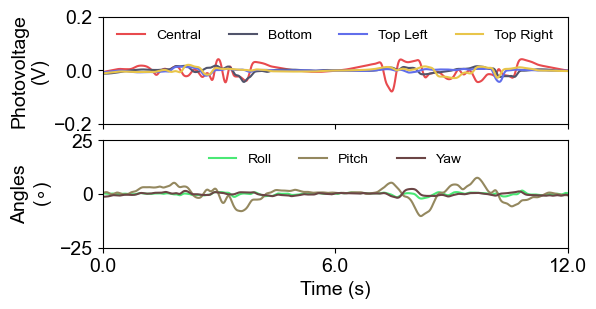

In [154]:
start = 155
offset = 20

start += offset
length = 12

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.2, 0.2)
ax1.set_yticks([-0.2, 0, 0.2])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-25, 25)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
# plt.savefig('../results/revision/lvl3.png', bbox_inches='tight', dpi=600)
plt.show()

## level 4

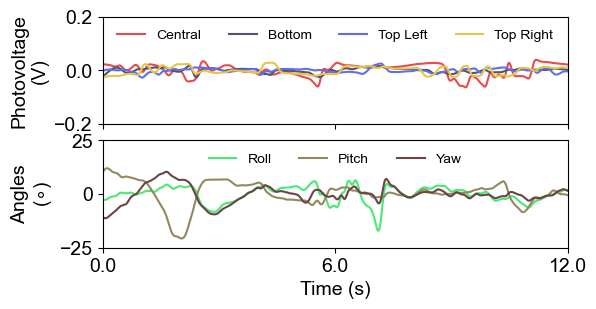

In [155]:
start = 155
offset = 116

start += offset
length = 12

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.2, 0.2)
ax1.set_yticks([-0.2, 0, 0.2])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-25, 25)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
# plt.savefig('../results/revision/lvl4.png', bbox_inches='tight', dpi=600)
plt.show()

## level 5

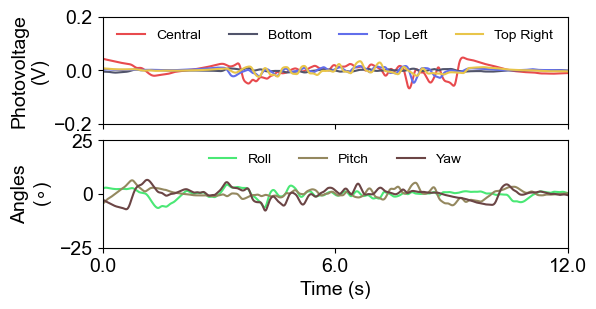

In [156]:
start = 155
offset = 197

start += offset
length = 12

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.2, 0.2)
ax1.set_yticks([-0.2, 0, 0.2])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-25, 25)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
# plt.savefig('../results/revision/lvl5.png', bbox_inches='tight', dpi=600)
plt.show()

## level 6

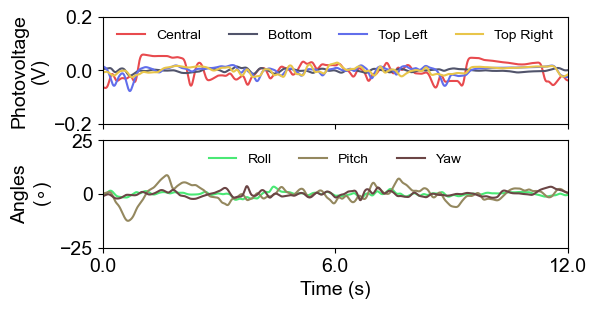

In [157]:
start = 155
offset = 260

start += offset
length = 12

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.2, 0.2)
ax1.set_yticks([-0.2, 0, 0.2])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-25, 25)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
# plt.savefig('../results/revision/lvl6.png', bbox_inches='tight', dpi=600)
plt.show()

## level 7

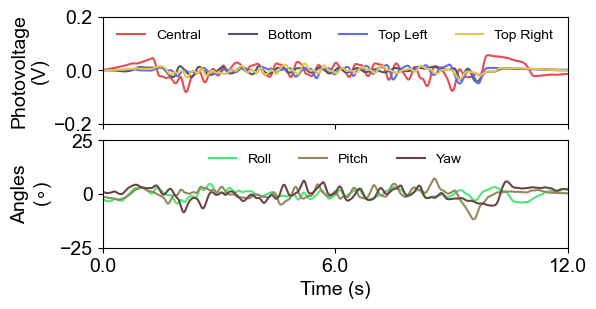

In [158]:
start = 155
offset = 303

start += offset
length = 12

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.2, 0.2)
ax1.set_yticks([-0.2, 0, 0.2])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-25, 25)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
# plt.savefig('../results/revision/lvl7.png', bbox_inches='tight', dpi=600)
plt.show()

# Phonetics

## Pitch

In [9]:
# audio = AudioSegment.from_file('../dataset/revision/voice.m4a')
# audio.export('../dataset/revision/voice.wav', format='wav')

<_io.BufferedRandom name='../dataset/revision/voice.wav'>

In [97]:
y, sr = librosa.load('../dataset/revision/voice.wav', sr=None)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=256, n_fft=8192, hop_length=1024)
S_dB = librosa.power_to_db(S, ref=np.max)

natural_notes = ['C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4', 'D4', 'E4', 'F4', 'G4', 'A4', 'B4']
note_freqs = {
    'C3': 130.81,
    'D3': 146.83,
    'E3': 164.81,
    'F3': 174.61,
    'G3': 196.00,
    'A3': 220.00,
    'B3': 246.94,
    'C4': 261.63,
    'D4': 293.66,
    'E4': 329.63,
    'F4': 349.23,
    'G4': 392.00,
    'A4': 440.00,
    'B4': 493.88
}

### C3

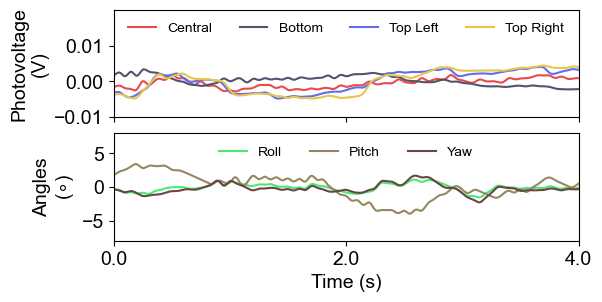

In [136]:
start = 832
offset = 29.5

start += offset
length = 4

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.01, 0.02)
ax1.set_yticks([-0.01, 0, 0.01])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-8, 8)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/c3.png', bbox_inches='tight', dpi=600)
plt.show()

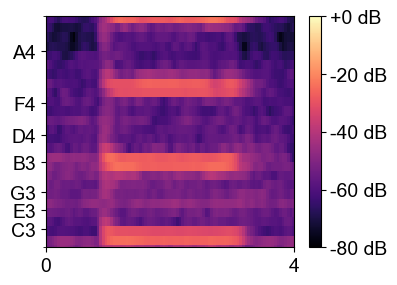

In [138]:
plt.figure(figsize=(4, 3))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

plt.xlim(15, 16)
plt.ylim(100, 500)

plt.xticks([15, 16], labels=[0, 4])
plt.yticks(list(note_freqs.values())[0::2], list(note_freqs.keys())[0::2],
           fontsize=14)

plt.xlabel('')
plt.ylabel('')
plt.savefig('../results/revision/quality/c3_spec.png', bbox_inches='tight', dpi=600)
plt.show()

### G3

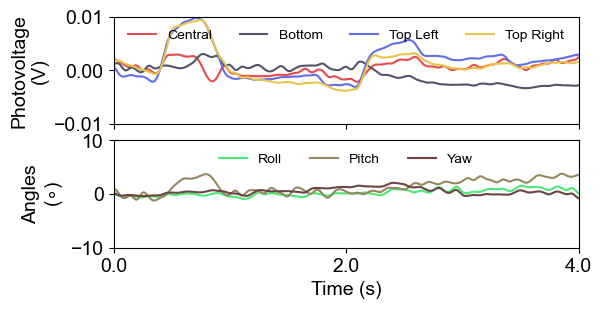

In [135]:
start = 832
offset = 47.3

start += offset
length = 4

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.01, 0.01)
ax1.set_yticks([-0.01, 0, 0.01])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-10, 10)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/g3.png', bbox_inches='tight', dpi=600)
plt.show()

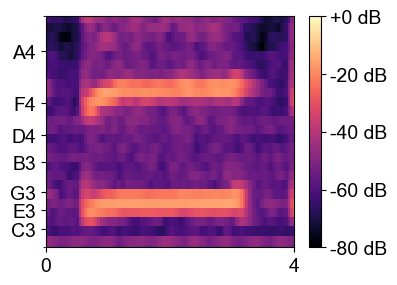

In [139]:
plt.figure(figsize=(4, 3))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

plt.xlim(23.2, 24.2)
plt.ylim(100, 500)

plt.xticks([23.2, 24.2], labels=[0, 4])
plt.yticks(list(note_freqs.values())[0::2], list(note_freqs.keys())[0::2],
           fontsize=14)

plt.xlabel('')
plt.ylabel('')
plt.savefig('../results/revision/quality/g3_spec.png', bbox_inches='tight', dpi=600)
plt.show()

### G4

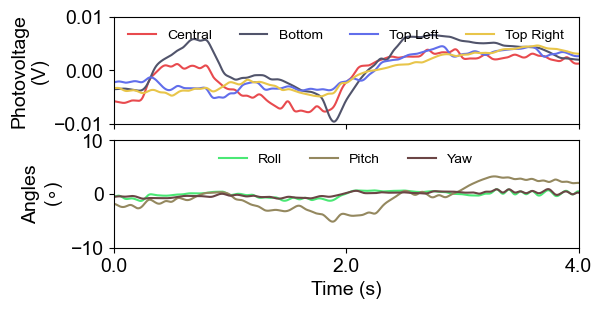

In [134]:
start = 832
offset = 81

start += offset
length = 4

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.01, 0.01)
ax1.set_yticks([-0.01, 0, 0.01])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-10, 10)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/g4.png', bbox_inches='tight', dpi=600)
plt.show()

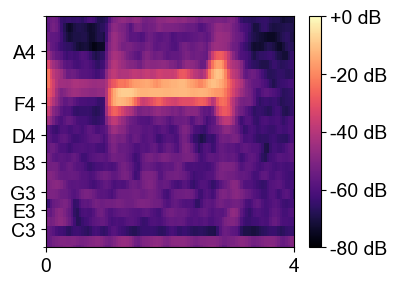

In [148]:
plt.figure(figsize=(4, 3))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

xl = 40.8
xr = 41.8

plt.xlim(xl, xr)
plt.ylim(100, 500)

plt.xticks([xl, xr], labels=[0, 4])
plt.yticks(list(note_freqs.values())[0::2], list(note_freqs.keys())[0::2],
           fontsize=14)

plt.xlabel('')
plt.ylabel('')
plt.savefig('../results/revision/quality/g4_spec.png', bbox_inches='tight', dpi=600)
plt.show()

## Style

### whisper

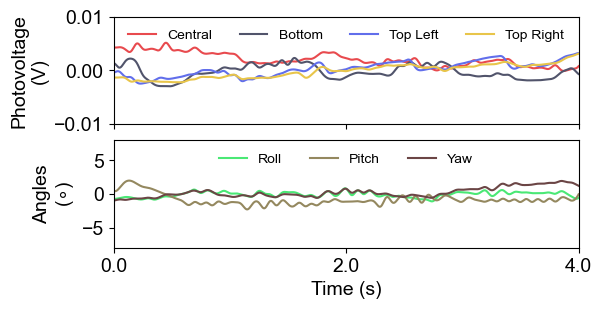

In [188]:
start = 832
offset = 95

start += offset
length = 4

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.01, 0.01)
ax1.set_yticks([-0.01, 0, 0.01])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-8, 8)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/whisper.png', bbox_inches='tight', dpi=600)
plt.show()

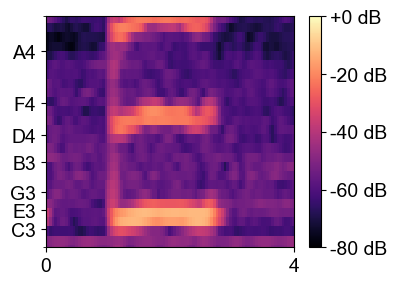

In [189]:
plt.figure(figsize=(4, 3))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

xl = 47.8
xr = 48.8

plt.xlim(xl, xr)
plt.ylim(100, 500)

plt.xticks([xl, xr], labels=[0, 4])
plt.yticks(list(note_freqs.values())[0::2], list(note_freqs.keys())[0::2],
           fontsize=14)

plt.xlabel('')
plt.ylabel('')
plt.savefig('../results/revision/quality/whisper_spec.png', bbox_inches='tight', dpi=600)
plt.show()

### loud

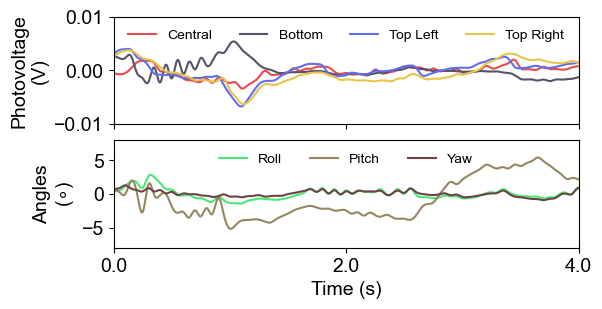

In [190]:
start = 832
offset = 103.5

start += offset
length = 4

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.01, 0.01)
ax1.set_yticks([-0.01, 0, 0.01])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-8, 8)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/loud.png', bbox_inches='tight', dpi=600)
plt.show()

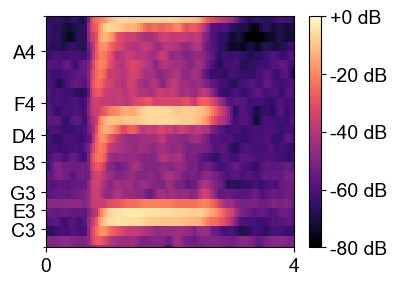

In [191]:
plt.figure(figsize=(4, 3))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

xl = 52.5
xr = 53.5

plt.xlim(xl, xr)
plt.ylim(100, 500)

plt.xticks([xl, xr], labels=[0, 4])
plt.yticks(list(note_freqs.values())[0::2], list(note_freqs.keys())[0::2],
           fontsize=14)

plt.xlabel('')
plt.ylabel('')
plt.savefig('../results/revision/quality/loud_spec.png', bbox_inches='tight', dpi=600)
plt.show()

### Falsetto

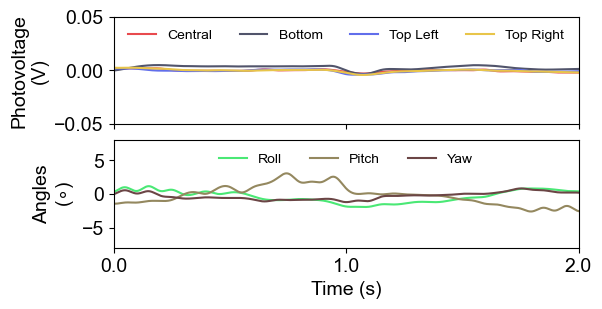

In [192]:
start = 832
offset = 113

start += offset
length = 2

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.05, 0.05)
ax1.set_yticks([-0.05, 0, 0.05])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-8, 8)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/falsetto.png', bbox_inches='tight', dpi=600)
plt.show()

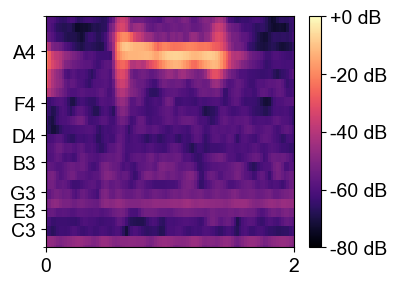

In [200]:
plt.figure(figsize=(4, 3))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

xl = 57.2
xr = 58.2

plt.xlim(xl, xr)
plt.ylim(100, 500)

plt.xticks([xl, xr], labels=[0, 2])
plt.yticks(list(note_freqs.values())[0::2], list(note_freqs.keys())[0::2],
           fontsize=14)

plt.xlabel('')
plt.ylabel('')
plt.savefig('../results/revision/quality/falsetto_spec.png', bbox_inches='tight', dpi=600)
plt.show()

### Head voice

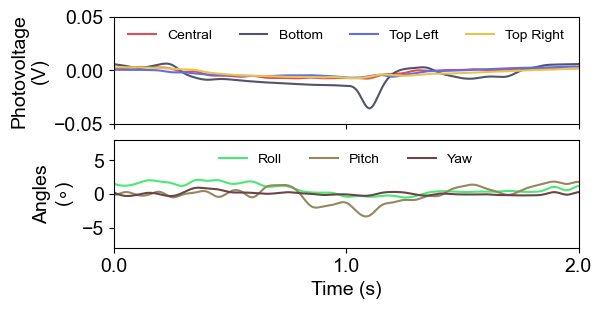

In [198]:
start = 832
offset = 120.5

start += offset
length = 2

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.05, 0.05)
ax1.set_yticks([-0.05, 0, 0.05])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-8, 8)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/quality/head_voice.png', bbox_inches='tight', dpi=600)
plt.show()

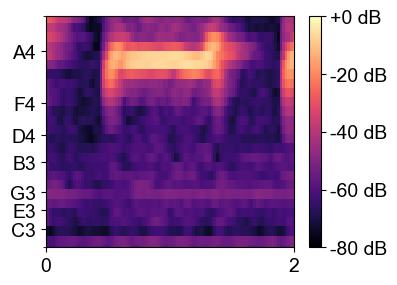

In [199]:
plt.figure(figsize=(4, 3))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')

xl = 60.3
xr = 61.3

plt.xlim(xl, xr)
plt.ylim(100, 500)

plt.xticks([xl, xr], labels=[0, 2])
plt.yticks(list(note_freqs.values())[0::2], list(note_freqs.keys())[0::2],
           fontsize=14)

plt.xlabel('')
plt.ylabel('')
plt.savefig('../results/revision/quality/head_voice_spec.png', bbox_inches='tight', dpi=600)
plt.show()

# Breath

In [172]:
path = '../dataset/revision/'
target_date = '2024-08-23'

csv_files = [f for f in os.listdir(path) if f.endswith('.csv') and target_date in f]

dfs = []
for f in csv_files:
    filepath = os.path.join(path, f)
    df = pd.read_csv(filepath, header=None)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.columns = [
    'timestamp',
    'pd1',
    'pd2',
    'pd3',
    'pd4',
    'roll',
    'pitch',
    'yaw']
df = df.drop_duplicates()
df['timestamp'] = df['timestamp'] / 1000
df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,25.128,0.3710,0.1471,0.3640,0.4725,-0.0558,63.4530,198.5810
1,25.178,0.3711,0.1471,0.3643,0.4728,0.6491,63.1988,199.1660
2,25.228,0.3719,0.1471,0.3645,0.4734,-0.4192,63.5120,198.2778
3,25.278,0.3719,0.1476,0.3646,0.4736,0.3990,63.3529,199.0543
4,25.328,0.3723,0.1479,0.3650,0.4739,-1.0483,63.5712,197.8486
...,...,...,...,...,...,...,...,...
735,61.878,0.3744,0.2234,0.3640,0.4648,-1.3687,83.3044,240.8203
736,61.928,0.3741,0.2214,0.3629,0.4633,-3.2422,82.9466,238.9311
737,61.978,0.3738,0.2235,0.3619,0.4631,-1.6537,83.4323,240.5576
738,62.028,0.3738,0.2226,0.3611,0.4635,1.4162,83.8795,243.6635


In [173]:
# fill the missed data by interpolation
full_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max() + 0.05, 0.05)
full_df = pd.DataFrame({'timestamp': full_timestamps})
df = pd.merge_asof(full_df, df, on='timestamp', direction='forward')
df.iloc[:, 1:] = df.iloc[:, 1:].interpolate(method='cubic')
df = df.dropna()

In [175]:
# interpolate to 1000 Hz
high_res_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max(), 0.001)
high_res_df = pd.DataFrame({'timestamp': high_res_timestamps})
for column in df.columns[1:]:
    interpolator = interp1d(df['timestamp'], df[column], kind='cubic', fill_value='extrapolate')
    high_res_signal = interpolator(high_res_timestamps)
    high_res_df[column] = high_res_signal
high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,25.128,0.371000,0.147100,0.364000,0.472500,-0.055800,63.453000,198.581000
1,25.129,0.370987,0.147110,0.364013,0.472501,-0.013406,63.435582,198.616459
2,25.130,0.370975,0.147119,0.364025,0.472502,0.027616,63.418801,198.650764
3,25.131,0.370963,0.147128,0.364037,0.472503,0.067281,63.402650,198.683926
4,25.132,0.370952,0.147136,0.364049,0.472505,0.105603,63.387119,198.715957
...,...,...,...,...,...,...,...,...
36896,62.024,0.373554,0.222374,0.360880,0.463792,-0.376310,83.629289,241.969164
36897,62.025,0.373541,0.222425,0.360884,0.463794,-0.512678,83.613328,241.836522
36898,62.026,0.373528,0.222480,0.360889,0.463796,-0.654206,83.596846,241.698805
36899,62.027,0.373514,0.222538,0.360894,0.463798,-0.800959,83.579838,241.555952


In [177]:
# butterworth filter
cutoff = [0.1, 5]
fs = 1000
for column in high_res_df.columns[1:]:
    sos = butter(2, cutoff, 'bandpass', output='sos', fs=fs)
    filtered_signal = sosfiltfilt(sos, high_res_df[column])
    high_res_df[column] = filtered_signal

high_res_df.iloc[:, 0] -= high_res_df.iloc[0, 0]
high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,0.000,0.000250,-0.003518,-0.000187,-1.042170e-05,2.839766,-3.837537,2.661314
1,0.001,0.000253,-0.003522,-0.000183,-5.350666e-06,2.844288,-3.843735,2.664798
2,0.002,0.000257,-0.003526,-0.000180,-1.776300e-07,2.848771,-3.849967,2.668249
3,0.003,0.000261,-0.003529,-0.000176,5.097587e-06,2.853211,-3.856231,2.671662
4,0.004,0.000265,-0.003533,-0.000173,1.047513e-05,2.857604,-3.862525,2.675035
...,...,...,...,...,...,...,...,...
36896,36.896,0.000004,0.000027,0.000006,-4.155266e-06,-0.014816,-0.000889,-0.015353
36897,36.897,0.000003,0.000023,0.000005,-3.570308e-06,-0.012649,-0.000754,-0.013109
36898,36.898,0.000003,0.000019,0.000004,-3.039203e-06,-0.010699,-0.000633,-0.011090
36899,36.899,0.000002,0.000016,0.000004,-2.560215e-06,-0.008956,-0.000526,-0.009285


In [178]:
color = ['#E84A4E', '#51546B', '#616EEB', '#E8C54A', '#4AE875', '#94885F', '#6B4545']

(-0.01, 0.01)

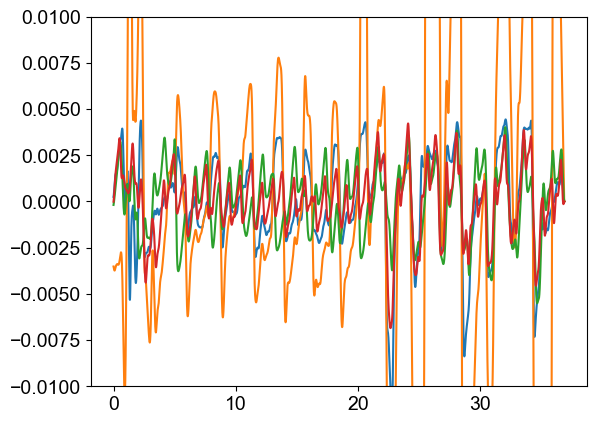

In [179]:
plt.plot(high_res_df['timestamp'], high_res_df['pd1'])
plt.plot(high_res_df['timestamp'], high_res_df['pd2'])
plt.plot(high_res_df['timestamp'], high_res_df['pd3'])
plt.plot(high_res_df['timestamp'], high_res_df['pd4'])
# plt.xlim(112.5, 115.5)
plt.ylim(-0.01, 0.01)

## nasal

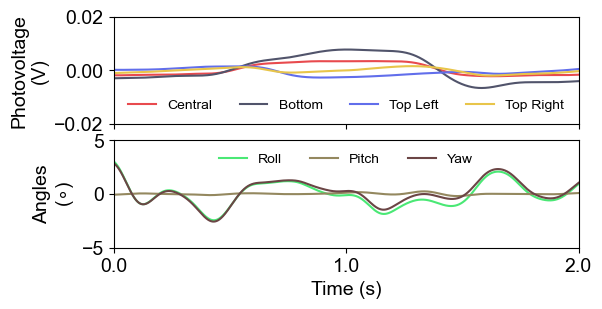

In [180]:
start = 12.5
offset = 0

start += offset
length = 2

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.02, 0.02)
ax1.set_yticks([-0.02, 0, 0.02])
ax1.legend(ncols=4, loc='lower center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-5, 5)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/breathing/nasal.png', bbox_inches='tight', dpi=600)
plt.show()

## oral

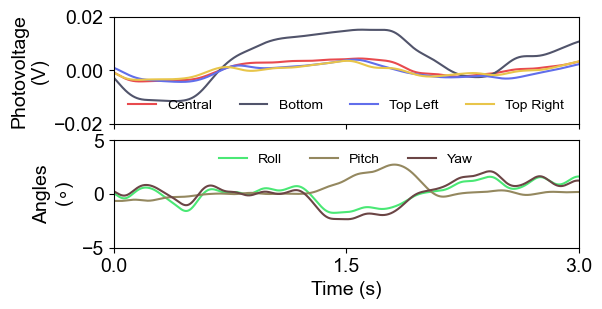

In [182]:
start = 30.5
offset = 0

start += offset
length = 3

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.02, 0.02)
ax1.set_yticks([-0.02, 0, 0.02])
ax1.legend(ncols=4, loc='lower center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-5, 5)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/breathing/oral.png', bbox_inches='tight', dpi=600)
plt.show()

# Anti-motion

In [131]:
path = '../dataset/revision/'
target_date = '2024-08-24'

csv_files = [f for f in os.listdir(path) if f.endswith('.csv') and target_date in f]

dfs = []
for f in csv_files:
    filepath = os.path.join(path, f)
    df = pd.read_csv(filepath, header=None)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.columns = [
    'timestamp',
    'pd1',
    'pd2',
    'pd3',
    'pd4',
    'roll',
    'pitch',
    'yaw']
df = df.drop_duplicates()
df['timestamp'] = df['timestamp'] / 1000
df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,19.078,0.3350,0.5689,0.3206,0.4370,-7.5050,74.2508,208.1015
1,19.128,0.3356,0.5703,0.3149,0.4369,-8.2195,72.8894,208.1069
2,19.178,0.3396,0.5688,0.3113,0.4381,-9.1681,71.8635,207.7493
3,19.228,0.3389,0.5699,0.3104,0.4385,-9.1849,70.9669,207.9350
4,19.278,0.3465,0.5728,0.3105,0.4384,-9.5470,70.3148,207.9052
...,...,...,...,...,...,...,...,...
754,56.778,0.3703,0.5148,0.3428,0.3424,-0.3008,51.3953,272.1389
755,56.828,0.3711,0.5131,0.3415,0.3425,-0.4541,50.8946,272.0355
756,56.878,0.3716,0.5139,0.3410,0.3434,-0.2660,50.5476,272.1417
757,56.928,0.3713,0.5115,0.3409,0.3436,-0.0794,50.0972,272.4583


In [132]:
# fill the missed data by interpolation
full_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max() + 0.05, 0.05)
full_df = pd.DataFrame({'timestamp': full_timestamps})
df = pd.merge_asof(full_df, df, on='timestamp', direction='forward')
df.iloc[:, 1:] = df.iloc[:, 1:].interpolate(method='cubic')
df = df.dropna()

In [133]:
# interpolate to 1000 Hz
high_res_timestamps = np.arange(df['timestamp'].min(), df['timestamp'].max(), 0.001)
high_res_df = pd.DataFrame({'timestamp': high_res_timestamps})
for column in df.columns[1:]:
    interpolator = interp1d(df['timestamp'], df[column], kind='cubic', fill_value='extrapolate')
    high_res_signal = interpolator(high_res_timestamps)
    high_res_df[column] = high_res_signal
high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,19.078,0.335000,0.568900,0.320600,0.437000,-7.505000,74.250800,208.101500
1,19.079,0.334865,0.568994,0.320472,0.436968,-7.505250,74.220440,208.111903
2,19.080,0.334737,0.569085,0.320345,0.436937,-7.506305,74.190205,208.121752
3,19.081,0.334618,0.569172,0.320218,0.436908,-7.508151,74.160095,208.131055
4,19.082,0.334507,0.569256,0.320091,0.436880,-7.510773,74.130110,208.139822
...,...,...,...,...,...,...,...,...
37846,56.924,0.371088,0.510430,0.340814,0.344603,-0.272037,50.621714,272.221652
37847,56.925,0.371091,0.510467,0.340811,0.344650,-0.282339,50.652764,272.204400
37848,56.926,0.371093,0.510508,0.340807,0.344699,-0.292948,50.684853,272.186497
37849,56.927,0.371096,0.510552,0.340804,0.344749,-0.303867,50.717994,272.167933


In [134]:
# butterworth filter
cutoff = [0.1, 20]
fs = 1000
for column in high_res_df.columns[1:]:
    sos = butter(2, cutoff, 'bandpass', output='sos', fs=fs)
    filtered_signal = sosfiltfilt(sos, high_res_df[column])
    high_res_df[column] = filtered_signal

high_res_df.iloc[:, 0] -= high_res_df.iloc[0, 0]
high_res_df

,timestamp,pd1,pd2,pd3,pd4,roll,pitch,yaw
0,0.000,-0.001112,-0.000248,0.012035,-0.001604,-2.790632,1.623446,-3.504111
1,0.001,-0.001202,-0.000175,0.011920,-0.001628,-2.796439,1.595155,-3.499029
2,0.002,-0.001292,-0.000102,0.011804,-0.001651,-2.802453,1.566527,-3.493963
3,0.003,-0.001380,-0.000028,0.011686,-0.001675,-2.808704,1.537623,-3.488952
4,0.004,-0.001467,0.000045,0.011568,-0.001698,-2.815223,1.508502,-3.484040
...,...,...,...,...,...,...,...,...
37846,37.846,0.000004,-0.000268,0.000007,-0.000279,0.074461,-0.215112,0.127578
37847,37.847,0.000003,-0.000242,0.000006,-0.000250,0.066614,-0.192583,0.114248
37848,37.848,0.000002,-0.000217,0.000005,-0.000222,0.059023,-0.170747,0.101318
37849,37.849,0.000002,-0.000191,0.000005,-0.000195,0.051736,-0.149752,0.088879


In [135]:
color = ['#E84A4E', '#51546B', '#616EEB', '#E8C54A', '#4AE875', '#94885F', '#6B4545']

(33.5, 35.0)

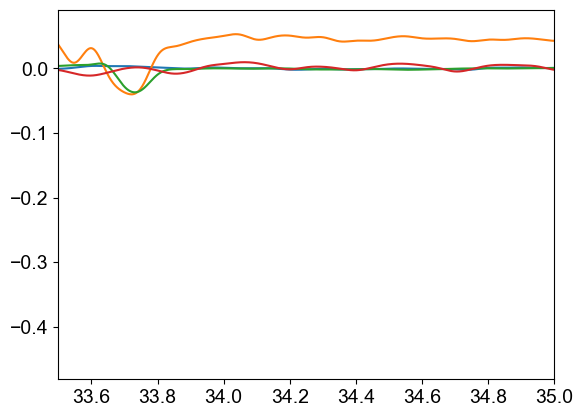

In [160]:
plt.plot(high_res_df['timestamp'], high_res_df['pd1'])
plt.plot(high_res_df['timestamp'], high_res_df['pd2'])
plt.plot(high_res_df['timestamp'], high_res_df['pd3'])
plt.plot(high_res_df['timestamp'], high_res_df['pd4'])
plt.xlim(33.5, 35)
# plt.ylim(-0.01, 0.01)

## stable

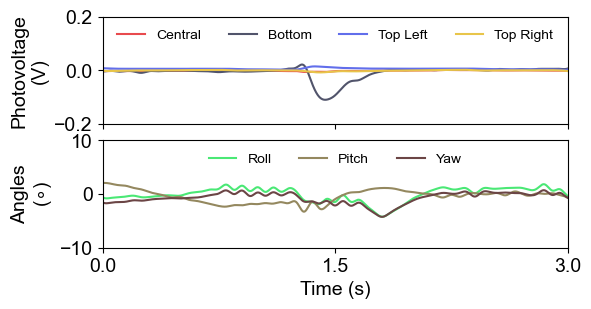

In [170]:
start = 10.5
offset = 0

start += offset
length = 3

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.2, 0.2)
ax1.set_yticks([-0.2, 0, 0.2])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-10, 10)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/anti-motion/stable.png', bbox_inches='tight', dpi=600)
plt.show()

## motion

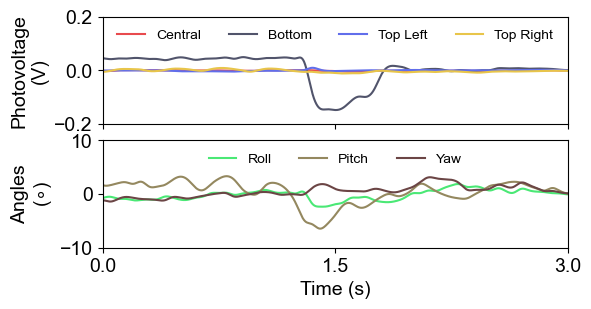

In [171]:
start = 34.7
offset = 0

start += offset
length = 3

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(6, 3), sharex=True)

ax1.plot(high_res_df['timestamp'], high_res_df['pd1'], label='Central', c=color[0])
ax1.plot(high_res_df['timestamp'], high_res_df['pd2'], label='Bottom', c=color[1])
ax1.plot(high_res_df['timestamp'], high_res_df['pd3'], label='Top Left', c=color[2])
ax1.plot(high_res_df['timestamp'], high_res_df['pd4'], label='Top Right', c=color[3])
ax1.set_xlim(start, start + length)
ax1.set_ylim(-0.2, 0.2)
ax1.set_yticks([-0.2, 0, 0.2])
ax1.legend(ncols=4, loc='upper center', frameon=False, fontsize=10)
ax1.set_ylabel('Photovoltage\n(V)')

ax2.plot(high_res_df['timestamp'], high_res_df['roll'], label='Roll', c=color[4])
ax2.plot(high_res_df['timestamp'], high_res_df['pitch'], label='Pitch', c=color[5])
ax2.plot(high_res_df['timestamp'], high_res_df['yaw'], label='Yaw', c=color[6])
ax2.set_ylim(-10, 10)
ax2.set_xticks([start, start + 0.5 * length, start + length], labels=[0.0, 0.5 * length, 1.0 * length])
ax2.legend(ncols=3, loc='upper center', frameon=False, fontsize=10)
ax2.set_ylabel('Angles\n($\circ$)')
ax2.set_xlabel('Time (s)')

plt.subplots_adjust(hspace=0.15)
plt.savefig('../results/revision/anti-motion/motion.png', bbox_inches='tight', dpi=600)
plt.show()